In [1]:
!pip install geopandas
!pip install cartopy
!pip install metpy==0.9
!pip uninstall shapely
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 16.8 MB/s 
     |████████████████████████████████| 6.3 MB 81.3 MB/s 
     |████████████████████████████████| 16.7 MB 65.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 15.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 51.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 59.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 54.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |█████████████████████████████

In [2]:
# import datasets directly from kaggle via API token
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ahsang","key":"d3ebeb853bab50eb612332b10793b9a7"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d open-flights/airline-database
!kaggle datasets download -d open-flights/flight-route-database
!kaggle datasets download -d thoudamyoihenba/airports

  0% 0.00/120k [00:00<?, ?B/s]
100% 120k/120k [00:00<00:00, 65.0MB/s]
  0% 0.00/375k [00:00<?, ?B/s]
100% 375k/375k [00:00<00:00, 118MB/s]
  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 99.2MB/s]


### Challenges
- Initially, the NavBlue provided datasets were missing column headers so the same datasets were fetched from Kaggle with an API key. 
- The Kaggle approach didn't work because the dataset was missing 2 fields: Type and Source which are included in the NavBlue dataset. 
- Hence, the NavBlue datasets were amended to include column headers with the schema provided.

### Problem Statement

We will evaluate the following statistics with respect to Ryanair's share of the European aviation market with respect to competing airline carriers:
1.   connections
    - number
2.   airports
    -   number
    -   percentage
3.   routes
    -   number
    -   shared
    -   exclusive


In [4]:
# import csv from google drive
from google.colab import drive
drive.mount('/content/drive')
# error datasets missing headers

Mounted at /content/drive


In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from google.colab import drive
drive.mount('/content/drive')

# check for 3 datasets in Google Drive
# Airlines, Airports, Routes

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/Airlines'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle/Airlines/airlines.csv
/content/drive/MyDrive/Kaggle/Airlines/airports.csv
/content/drive/MyDrive/Kaggle/Airlines/routes.csv


In [6]:
# import airlines as a pandas dataframe

airlines_df = (
    pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/airlines.csv', 
                header=None, names=['id','name','alias','iata','icao','callsign','country','active'],
                na_values=['\\N', '-', 'NAN', 'unknown']).assign(airline_id=lambda df: df.id.map(str)))

airlines_df

,id,name,alias,iata,icao,callsign,country,active,airline_id
0,-1,Unknown,NaN,NaN,NaN,NaN,NaN,Y,-1
1,1,Private flight,NaN,NaN,NaN,NaN,NaN,Y,1
2,2,135 Airways,NaN,NaN,GNL,GENERAL,United States,N,2
3,3,1Time Airline,NaN,1T,RNX,NEXTIME,South Africa,Y,3
4,4,2 Sqn No 1 Elementary Flying Training School,NaN,NaN,WYT,NaN,United Kingdom,N,4
...,...,...,...,...,...,...,...,...,...
6157,21248,GX Airlines,NaN,NaN,CBG,SPRAY,China,Y,21248
6158,21251,Lynx Aviation (L3/SSX),NaN,NaN,SSX,Shasta,United States,N,21251
6159,21268,Jetgo Australia,NaN,JG,NaN,NaN,Australia,Y,21268
6160,21270,Air Carnival,NaN,2S,NaN,NaN,India,Y,21270


In [7]:
# import airports as a pandas dataframe

airports_df = (pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/airports.csv',
                header=None, names=['id', 'name', 'city', 'country', 'iata', 'icao', 'latitude', 
                                    'longitude', 'altitude', 'timezone', 'dst', 'tz', 'type', 'source'],
                na_values=['\\N', '-', 'NAN', 'unknown']).set_index('id').reset_index(drop=True))

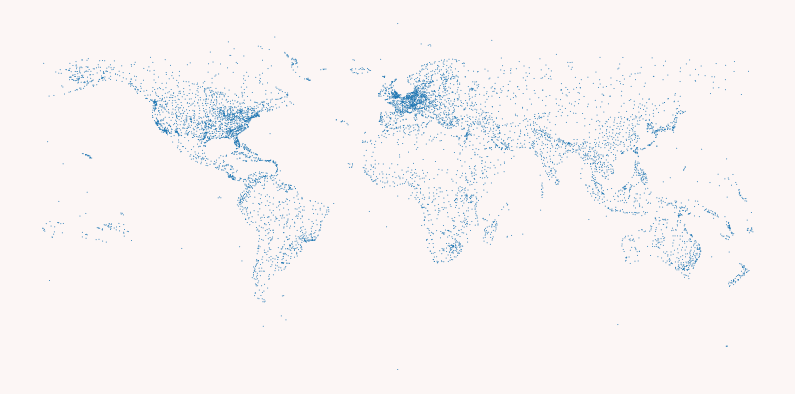

In [8]:
# global visualization of airport coordinates

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)

ax.scatter(airports_df['longitude'], airports_df['latitude'], s=1, alpha=1, edgecolors='none')
ax.axis('off')

plt.show()

In [9]:
# import routes as a pandas dataframe
# map all airport ID's and IATA codes to strings
routes_df = (pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/routes.csv', 
                header=None, names=['airline', 'airline_id', 'source', 'source_id', 'destination', 
                                    'destination_id', 'codeshare', 'stops', 'equipment'],
                na_values=['\\N', '-', 'NAN', 'unknown'])
    .dropna(subset=['airline_id', 'source_id', 'destination_id'], how='any')
    .assign(airline_id=lambda df: df.airline_id.map(int).map(str),
            source=lambda df: df.source.map(str).map(str),
            source_id=lambda df: df.source_id.map(int).map(str),
            destination=lambda df: df.destination.map(str).map(str),
            destination_id=lambda df: df.destination_id.map(int).map(str),
            route_id=lambda df: df[['source', 'destination']].apply(sorted, axis=1).map('_'.join)))

# Global Routing Visualizations
1. Duplicate Airports Dataframe
  - Source Airport Dataframe
  - Destination Airport Dataframe
2. Merge source to routes dataframe based on IATA codes
3. Merge destination to routes dataframe based on IATA codes
4. LineString's to connect 
  - source_(longitude, latitude)
  - destination_(longitude, latitude)

In [10]:
# duplicate dataframe for source airports
source_airports = airports_df[['name', 'iata', 'icao', 'latitude', 'longitude']]
destination_airports = source_airports.copy()

# duplicate dataframe for destination airports
source_airports.columns = ['source_' + str(col) for col in source_airports.columns]
destination_airports.columns = ['destination_' + str(col) for col in destination_airports.columns]

In [11]:
# merge the source and destination dataframes to construct a routes dataframe
routes = routes_df[['source', 'destination']]
routes = pd.merge(routes, source_airports, left_on='source', right_on='source_iata')
routes = pd.merge(routes, destination_airports, left_on='destination', right_on='destination_iata')

print(routes.columns)

Index(['source', 'destination', 'source_name', 'source_iata', 'source_icao',
       'source_latitude', 'source_longitude', 'destination_name',
       'destination_iata', 'destination_icao', 'destination_latitude',
       'destination_longitude'],
      dtype='object')


In [12]:
import geopandas as gpd
from shapely.geometry import LineString

# implement LineString's to connect source_(longitude, latitude) with destination_(longitude, latitude)

geometry = [LineString([[routes.iloc[i]['source_longitude'], routes.iloc[i]['source_latitude']], [routes.iloc[i]['destination_longitude'], routes.iloc[i]['destination_latitude']]]) for i in range(routes.shape[0])]
routes = gpd.GeoDataFrame(routes, geometry=geometry, crs='EPSG:4326')
print(routes)

      source destination                       source_name source_iata  \
0        AER         KZN       Sochi International Airport         AER   
1        ASF         KZN                 Astrakhan Airport         ASF   
2        CEK         KZN     Chelyabinsk Balandino Airport         CEK   
3        DME         KZN  Domodedovo International Airport         DME   
4        DME         KZN  Domodedovo International Airport         DME   
...      ...         ...                               ...         ...   
66088    YRG         YMN                   Rigolet Airport         YRG   
66089    YSO         YMN                 Postville Airport         YSO   
66090    YSO         YHO                 Postville Airport         YSO   
66091    JCK         RCM               Julia Creek Airport         JCK   
66092    TRO         GFN                     Taree Airport         TRO   

      source_icao  source_latitude  source_longitude  \
0            URSS        43.449902         39.956600   

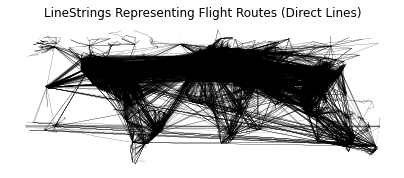

In [13]:
# plot black routes on a white background (direct lines)

fig = plt.figure(facecolor='white')
ax = plt.axes()

fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('white')

routes.plot(ax=ax, color='black', linewidth=0.1)
plt.axis('off')
plt.title('LineStrings Representing Flight Routes (Direct Lines)')
plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')

plt.show()

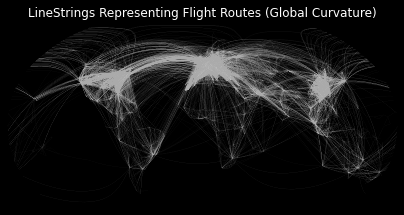

In [14]:
import cartopy.crs as ccrs

# plot white routes on a black background (global curvature)

fig = plt.figure(facecolor='black')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)
plt.axis('off')
plt.title('LineStrings Representing Flight Routes (Global Curvature)', color='w')
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)

plt.show()

In [15]:
# Second approach to duplicate airports (source and destination)
# Merge source and destination dataframes using piping methodology

routes2 = (routes_df.pipe(pd.merge, 
          airlines_df[['id', 'iata', 'name', 'country']],
          left_on=['source'], right_on=['iata'], how='left')
          .pipe(pd.merge, 
          airports_df[['iata', 'country', 'city', 'latitude', 'longitude']]
          .rename(columns=lambda col: 'source_' + col),
          left_on=['source'], right_on=['source_iata'], how='left')
          .pipe(pd.merge, 
          airports_df[['iata', 'country', 'city', 'latitude', 'longitude']]
          .rename(columns=lambda col: 'destination_' + col),
          left_on=['destination'], right_on=['destination_iata'], how='right')
          .assign(is_national_route=lambda df: df.source_country == df.destination_country)
          .assign(dist=lambda df: np.sqrt(
          (df.destination_longitude - df.source_longitude) ** 2 
          + (df.destination_latitude - df.source_latitude) ** 2)))

routes2.sort_values(by='airline', ascending=True).value_counts('airline')

airline
FR    2484
AA    2351
UA    2179
DL    1981
US    1960
      ... 
UD       2
6Y       2
A8       1
Q5       1
EW       1
Length: 546, dtype: int64

In [16]:
# ensure white background
plt.rcParams['figure.facecolor'] = 'w'

In [17]:
# unique connections by top 5 airlines
connections = (routes2.groupby('airline').route_id
               .nunique().sort_values()[::-1]
               .rename('# Connections')
               .rename_axis('Airline'))

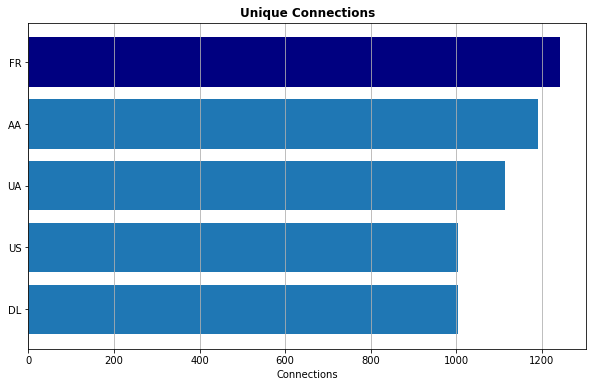

In [18]:
# plot unique connections by top 5 airlines
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(connections.index[:5][::-1], connections[:5][::-1])
ax.barh('FR', connections['FR'], color='navy')

ax.set_xlabel('Connections')

ax.set_title('Unique Connections', weight='bold')
ax.grid(axis='x')
plt.show()

In [19]:
# exclusive connections by top 5 airlines
exclusive = (routes2.groupby('route_id').airline_id.nunique()
             [lambda x: x == 1].reset_index()
            .pipe(pd.merge, routes2[['route_id', 'airline']], how='left')
            .groupby('airline').route_id
            .nunique().sort_values()[::-1]
            .rename('# Exclusive Connections')
            .rename_axis('Airline'))

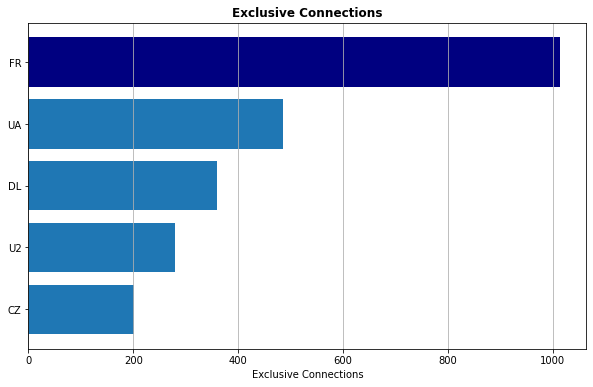

In [20]:
# plot exclusive connections by top 5 airlines
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(exclusive.index[:5][::-1], exclusive[:5][::-1])
ax.barh('FR', exclusive.loc['FR'], color='navy')
ax.set_xlabel('Exclusive Connections')
ax.set_title('Exclusive Connections', weight='bold')
ax.grid(axis='x')

plt.show()

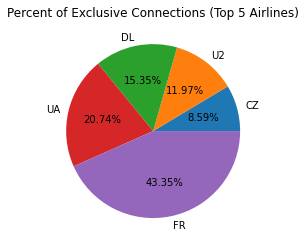

In [21]:
# plot percent of exclusive connections by top 5 airlines
fig, ax = plt.subplots()

ax.pie(exclusive[:5][::-1], autopct=lambda pct: ('%.2f' % pct) + '%' if pct > 4 else '',
       labels=[al if i < 5 else '' for i, al in enumerate(exclusive[:5][::-1].index)])
plt.title('Percent of Exclusive Connections (Top 5 Airlines)')
plt.show()

In [22]:
# number of base aiports for Ryanair compared to Top 5 Airlines
airports = (routes2.groupby('airline')
    .source_id.nunique().sort_values()[::-1]
    .rename('# Airports').rename_axis('Airline'))

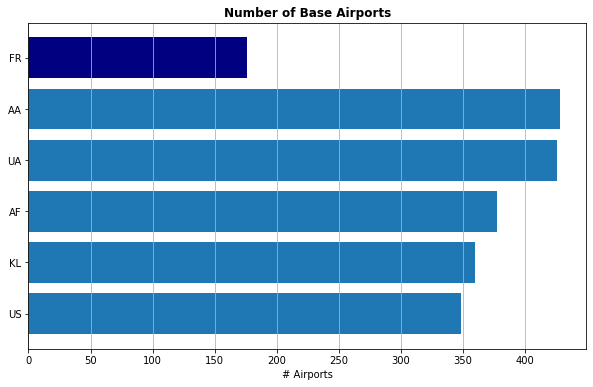

In [23]:
# plot number of base aiports for Ryanair compared to Top 5 Airlines
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(airports.index[:5][::-1], airports[:5][::-1])
ax.barh('FR', airports.loc['FR'], color='navy')
ax.set_xlabel('# Airports')
ax.set_title('Number of Base Airports', weight='bold')
ax.grid(axis='x')

plt.show()

In [24]:
airports

Airline
AA    428
UA    426
AF    377
KL    360
US    348
     ... 
I4      2
UD      2
Q5      1
A8      1
EW      1
Name: # Airports, Length: 546, dtype: int64

In [25]:
# number of base countries for Ryanair compared to Top 5 Airlines
countries = (routes2.groupby('airline')
    .source_country.nunique().sort_values()[::-1]
    .rename('# Countries').rename_axis('Airline'))

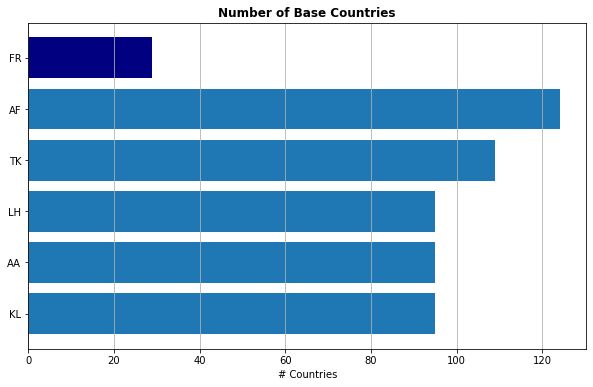

In [26]:
# plot number of base aiports for Ryanair compared to Top 5 Airlines
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(countries.index[:5][::-1], countries[:5][::-1])
ax.barh('FR', countries.loc['FR'], color='navy')
ax.set_xlabel('# Countries')
ax.set_title('Number of Base Countries', weight='bold')
ax.grid(axis='x')

plt.show()

In [27]:
# number of average competitors per airport for Ryanair compared to Top 5 Airlines
competitors = (routes2.groupby('source_id').airline_id.nunique().sub(1)
    .to_frame('n_competitors').reset_index()
    .pipe(pd.merge, routes2[['source_id', 'airline']].drop_duplicates()))

average_competitors = (competitors.groupby('airline')
    .n_competitors.mean().sort_values()[::-1])

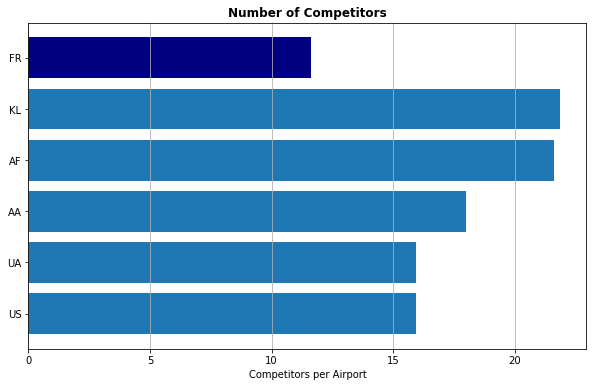

In [28]:
# plot number of average competitors per airport for Ryanair compared to Top 5 Airlines
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(*list(zip(*list(average_competitors.reindex(index=airports.index[:5]).sort_values().iteritems()))))
ax.barh('FR', average_competitors.loc['FR'], color='navy')
ax.set_xlabel('Competitors per Airport')
ax.set_title('Number of Competitors', weight='bold')
ax.grid(axis='x')

plt.show()

In [29]:
# number of average airport presence for Ryanair compared to Top 5 Airlines
presence = (routes2.groupby('source_id').airline
    .apply(lambda x: x.value_counts(normalize=True).rename_axis('airline'))
    .rename('airport_presence').reset_index())

average_presence = (presence.groupby('airline')
    .airport_presence.mean().sort_values()[::-1])

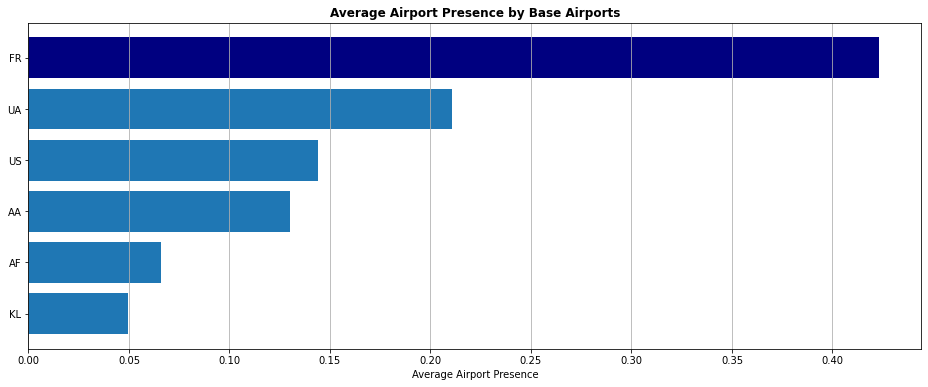

In [30]:
# plot number of average airport presence by base airports for Ryanair compared to Top 5 Airlines
fig, ax = plt.subplots(figsize=(16,6))

top5 = average_presence.reindex(index=airports.index[:5]).sort_values()
ax.barh(top5.index, top5)
ax.barh('FR', average_presence.loc['FR'], color='navy')
ax.set_xlabel('Average Airport Presence')
ax.set_title('Average Airport Presence by Base Airports', weight='bold')
ax.grid(axis='x')
plt.show()

# Conclusions
Globally, Ryanair has the highest number of:
- Unique Connections
- Exclusive Connections (43%)
- Average Airport Presence by Number of Base Airports (42%)

Furthermore, it has the least number of:
- Competitors
  - Routing Advantage
- Base Countries
  - Reduced operational expenditures

# Future Work
- Further investigation required:
  - Aircraft passenger saturation
  - Fuel to Payload ratio
  - Maintenance time and cost
  - Types of aircraft (single / dual / quad)
  - Average airborne time per aircraft type
  - Average hangar time per aircraft type

# Takeaways
Therefore, Ryanair has a competitive advantage within Europe as well as globally in terms of base airports in fewer countries to reduce operating overhead as well as a higher competitive advantage with the most unique and exclusive connections. We hope this will support Ryanair's profit margin sufficiently so they are not pressured to charge passengers for using onboard restrooms (nice try team).